In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import normaltest

import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split

import sympy as sym
from sympy.utilities.lambdify import lambdify
sym.init_printing()

# Modelos

## Objetivos


    - Formular matematicamente modelos para sistemas.
    - Utilizar algoritmos estadísticos para el ajuste de modelos.

**Caso**

Se tiene una tabla con los datos temporales de la entrada $step.y$ y la salida $add.y$ de un sistema.

Se pretende encontrar una expresión matemáatica que relacione las señales de entrada y salida.

*Se leen los datos.*

In [7]:
ruta = '/content/drive/Shareddrives/JPDP/2023_2/CI/'
fn = 'orden2Variables2.csv'

datos = pd.read_csv(ruta + fn).drop_duplicates()
datos.tail()

,time,tf.y,step.y,add.y
19999,199.950000,0.111111,1,0.104045
20000,199.970001,0.111111,1,0.104045
20001,199.980000,0.111111,1,0.104045
20002,199.980000,0.111111,1,0.110629
20003,200.000000,0.111111,1,0.110629


In [8]:
datos.rename(columns = {'step.y':'U','tf.y':'Y'},inplace=True)
datos = datos.groupby(by= 'time').first().reset_index()
datos.head()

,time,Y,U,add.y
0,0.000000,0.0,0,-0.014513
1,0.029999,0.0,0,-0.014513
2,0.030000,0.0,0,-0.014513
3,0.059997,0.0,0,-0.010139
4,0.060000,0.0,0,-0.010139


Se visualiza el comportamiento temporal.

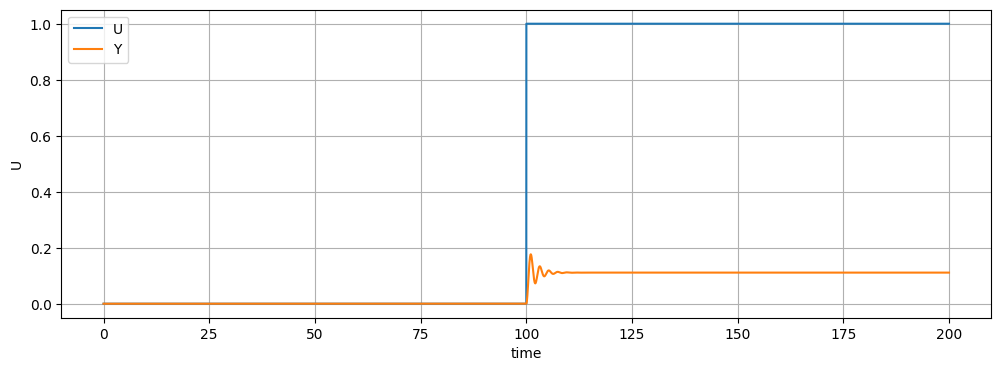

In [9]:
plt.figure(figsize=(12,4)) # Determina el tamaño de la gráfica
sns.lineplot(data = datos,x='time',y='U',label='U')
sns.lineplot(data = datos,x='time',y='Y',label='Y')
plt.grid()# Grafica una cuadrícula

Observe
- La señal de entrada es un escalón unitario.
- La señal de salida muestra un comportamiento subamortiguado de orden 2.
- Las señales se mantienen relativamente constantes antes del instante $100 s$ y después de los $105s$.

**Hipótesis 0**

El modelo tiene la forma:
$$y[k] = au[k] + b$$


In [10]:
hipotesis0 = 'Y ~ U'
Modelo0 = sm.formula.ols(formula = hipotesis0,data = datos).fit()
Modelo0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.203e+06
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:33:29   Log-Likelihood:                 49656.
No. Observations:               13335   AIC:                        -9.931e+04
Df Residuals:                   13333   BIC:                        -9.929e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.96e-16   7.15e-05   1.11e-11      1.000      -0.000       0.000
U              0.1110      0.000   1096.846      0.000       0.111       0.111
==============================================================================
Omnibus:                    15511.365   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15015922.891
Skew:                          -5.295   Prob(JB):                         0.00
Kurtosis:                     167.052   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

El $R^2$ indica que este modelo explica el $95\%$ de las variaciones de la señal de salida, sin embargo este modelo es estático.

# Análisis

- $AIC$: Esta métrica permite identificar el modelo que mejor explica las variaciones en la variable dependiente, a partir de una métrica de similitud $L$, penalizando la cantidad $K$ de parámetros. Se calcula como $2K-\ln(L)$.

- $R^2$: Este coeficiente indica  qué porcentaje de la variación que se presenta en la variable dependiente se explica por las variables independientes.

- Estadístico $F$ y $Prob(F)$: Indican la calidad del ajuste del modelo a los datos. Particularmente, $Prob(F)$ cercanos a $0$ permiten rechazar la hipótesis nula de independencia entre la variable dependiente y la que se consideró independiente.


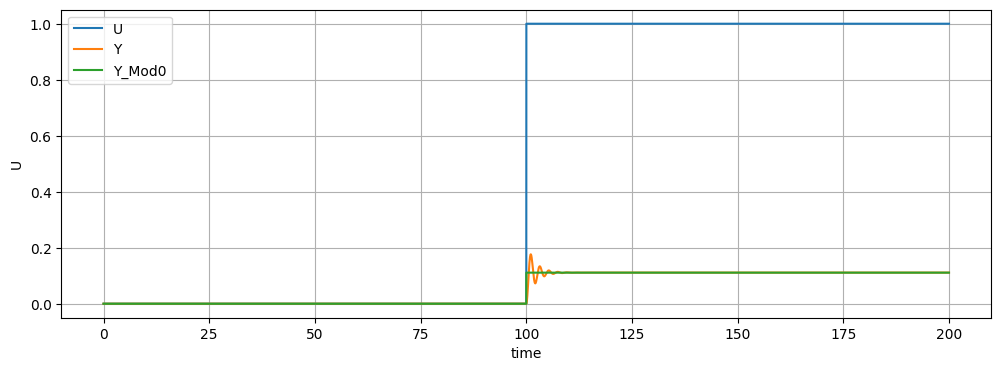

In [11]:
datos['Y_Mod0'] = Modelo0.predict(exog= datos)
plt.figure(figsize=(12,4)) # Determina el tamaño de la gráfica
sns.lineplot(data = datos,x='time',y='U',label='U')
sns.lineplot(data = datos,x='time',y='Y',label='Y')
sns.lineplot(data = datos,x='time',y='Y_Mod0',label='Y_Mod0')
plt.grid()# Grafica una cuadrícula

¿Por qué el ajuste tiene un $R^2$ tan alto sin seguir la dinámica?

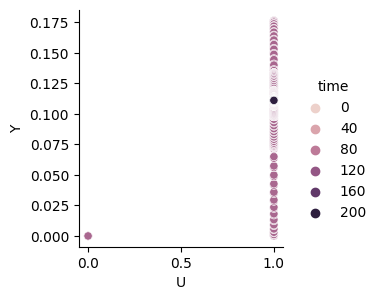

In [12]:
sns.pairplot(datos,
             x_vars = ['U'],
             y_vars = ['Y'],
             height= 3, hue = 'time') # Scatter entre todas las variables exceptuando time y samples

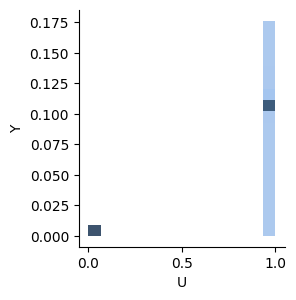

In [13]:
sns.pairplot(datos,
             x_vars = ['U'],
             y_vars = ['Y'],
             height= 3,kind='hist') # Scatter entre todas las variables exceptuando time y samples


- Las gráficas muestran que hay una alta concentración de datos con $y=0$ y $y=0.11$.
- Las variaciones que se presentan debido a las dinámicas del sistema no pueden ser explicadas con el Modelo0, pues no es dinámico.


Incorpore las señales en instantes anteriores.

In [15]:
datos['U1'] = datos['U'].shift(periods= 1)
datos['U2'] = datos['U'].shift(periods= 2)
datos['U3'] = datos['U'].shift(periods= 3)

datos['Y1'] = datos['Y'].shift(periods= 1)
datos['Y2'] = datos['Y'].shift(periods= 2)
datos['Y3'] = datos['Y'].shift(periods= 3)

datos = datos.dropna().reset_index().drop(columns= 'index')
datos.head()

,time,Y,U,add.y,Y_Mod0,U1,U2,U3,Y1,Y2,Y3
0,0.059997,0.0,0,-0.010139,7.959528e-16,0.0,0.0,0.0,0.0,0.0,0.0
1,0.060000,0.0,0,-0.010139,7.959528e-16,0.0,0.0,0.0,0.0,0.0,0.0
2,0.089996,0.0,0,-0.003360,7.959528e-16,0.0,0.0,0.0,0.0,0.0,0.0
3,0.090000,0.0,0,-0.003360,7.959528e-16,0.0,0.0,0.0,0.0,0.0,0.0
4,0.119994,0.0,0,0.015015,7.959528e-16,0.0,0.0,0.0,0.0,0.0,0.0


**Hipótesis 1**

El modelo tiene la forma:
$$y[k] = a_0u[k] + a_1u[k-1] + b_1y[k-1] + c$$


In [16]:
hipotesis1 = 'Y ~ U + U1 + Y1'
Modelo1 = sm.formula.ols(formula = hipotesis1,data = datos).fit()
Modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.681e+08
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:53:51   Log-Likelihood:                 89823.
No. Observations:               13332   AIC:                        -1.796e+05
Df Residuals:                   13328   BIC:                        -1.796e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.184e-16   3.51e-06  -6.21e-11      1.000   -6.89e-06    6.89e-06
U              0.0001      0.000      0.390      0.697      -0.000       0.001
U1             0.0016      0.000      5.330      0.000       0.001       0.002
Y1             0.9852      0.000   2316.244      0.000       0.984       0.986
==============================================================================
Omnibus:                    20639.099   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32627353.633
Skew:                           9.350   Prob(JB):                         0.00
Kurtosis:                     244.631   Cond. No.                         230.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

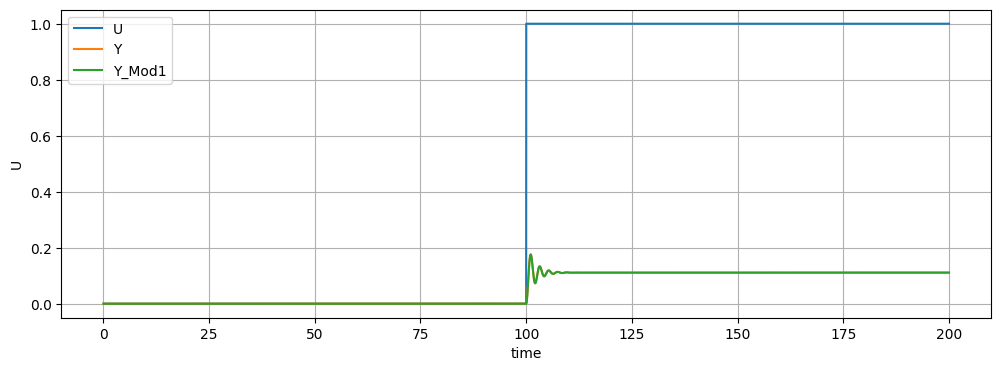

In [17]:
datos['Y_Mod1'] = Modelo1.predict(exog= datos)
plt.figure(figsize=(12,4)) # Determina el tamaño de la gráfica
sns.lineplot(data = datos,x='time',y='U',label='U')
sns.lineplot(data = datos,x='time',y='Y',label='Y')
sns.lineplot(data = datos,x='time',y='Y_Mod1',label='Y_Mod1')
plt.grid()# Grafica una cuadrícula

In [18]:
Ysim = np.zeros(len(datos))
Y1 = 0
for index, row in datos.copy().iterrows():
  df = pd.DataFrame(data={'U':[row['U']], 'U1':[row['U1']],
                     'Y1':[Y1]})
  Y = Modelo1.predict(exog=df)
  Ysim[index] = Y[0]
  Y1 = Y[0]
datos['Ysim_mod1'] = Ysim

(95.0, 105.0)

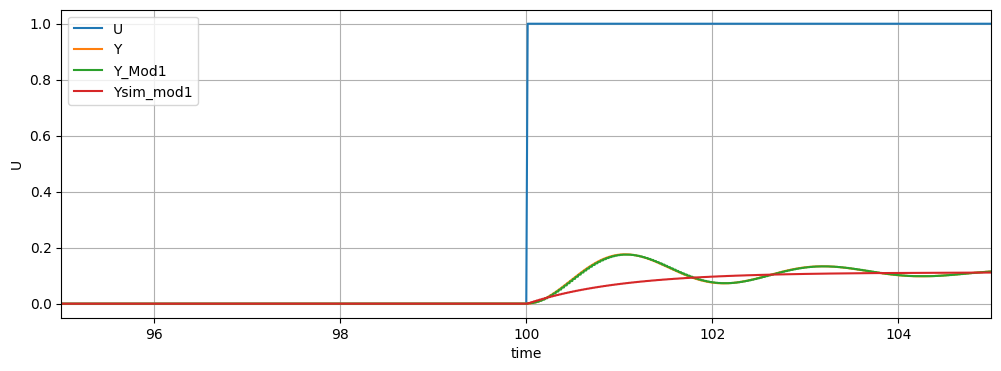

In [21]:
plt.figure(figsize=(12,4)) # Determina el tamaño de la gráfica
sns.lineplot(data = datos,x='time',y='U',label='U')
sns.lineplot(data = datos,x='time',y='Y',label='Y')
sns.lineplot(data = datos,x='time',y='Y_Mod1',label='Y_Mod1')
sns.lineplot(data = datos,x='time',y='Ysim_mod1',label='Ysim_mod1')
plt.grid()# Grafica una cuadrícula
plt.xlim([95,105])

## Balanceo

El sistema tiene etapas en su funcionamiento y pasa entre estas etapas durante su funcionamiento. Dos etapasa de fácil entendimiento son:

- Poco cambio.
- Mucho cambio.

Agregue al dataframe una etiqueta para cada instante.

(95.0, 110.0)

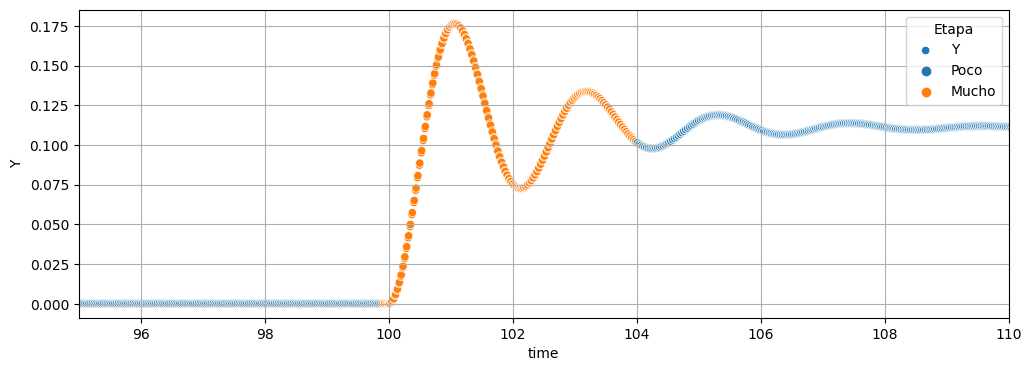

In [23]:
datos['Etapa'] = np.where((datos['time']<99.9) | (datos['time']>104),'Poco','Mucho')
plt.figure(figsize=(12,4)) # Determina el tamaño de la gráfica
sns.scatterplot(data = datos,x='time',y='Y',label='Y',hue='Etapa')
plt.grid()# Grafica una cuadrícula
plt.xlim([95,110])

Compare la cantidad de muestras en cada etapa

<Axes: xlabel='Etapa', ylabel='Count'>

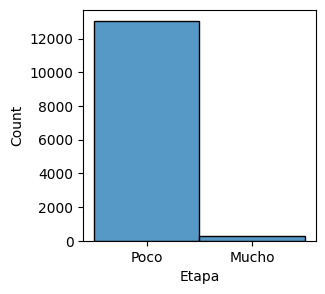

In [24]:
plt.figure(figsize=(3,3)) # Determina el tamaño de la gráfica

sns.histplot(data= datos, x='Etapa')

Como hay muchos más datos en la etapa de **Poco** cambio, el modelo ajustado tendra sesgo para aproximarse a estos datos y no podrá ajustarse a en los instantes de **Mucho** cambio.

Para balancear el dataset, debe tomarse un conjunto de cada etapa con cantidades similares.

In [25]:
nEtapas = datos[['Etapa','U']].groupby(by='Etapa').count().rename(columns={'U':'Cantidad'}).reset_index()
nEtapas

,Etapa,Cantidad
0,Mucho,274
1,Poco,13058


,time,Y,U,add.y,Y_Mod0,U1,U2,U3,Y1,Y2,Y3,Y_Mod1,Ysim_mod1,Etapa
6657,99.900000,0.000000,0,0.009671,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Mucho
6658,99.925004,0.000000,0,-0.011349,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Mucho
6659,99.930000,0.000000,0,-0.011349,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Mucho
6660,99.955002,0.000000,0,-0.010179,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Mucho
6661,99.960000,0.000000,0,-0.010179,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Mucho
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504,142.590000,0.111111,1,0.113790,1.109904e-01,1.0,1.0,1.0,0.111111,0.111111,0.111111,1.111260e-01,1.121137e-01,Poco
932,14.039298,0.000000,0,-0.013385,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473329e-14,Poco
6259,93.930000,0.000000,0,0.003370,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Poco
1267,19.050000,0.000000,0,-0.001790,7.959528e-16,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.183974e-16,-1.473331e-14,Poco


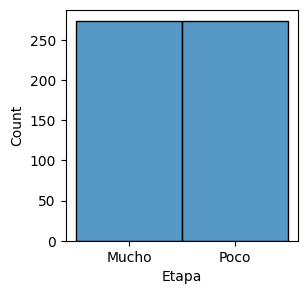

In [27]:
datosPoco = datos[datos['Etapa']=='Poco']
datosMucho = datos[datos['Etapa']=='Mucho']
nPoco = len(datosPoco)
nMucho = len(datosMucho)
if nPoco < nMucho:
  datosBal = pd.concat([datosPoco,datosMucho.sample(n=nPoco)])
else:
  datosBal = pd.concat([datosMucho,datosPoco.sample(n=nMucho)])
plt.figure(figsize=(3,3)) # Determina el tamaño de la gráfica

sns.histplot(data= datosBal, x='Etapa')
datosBal

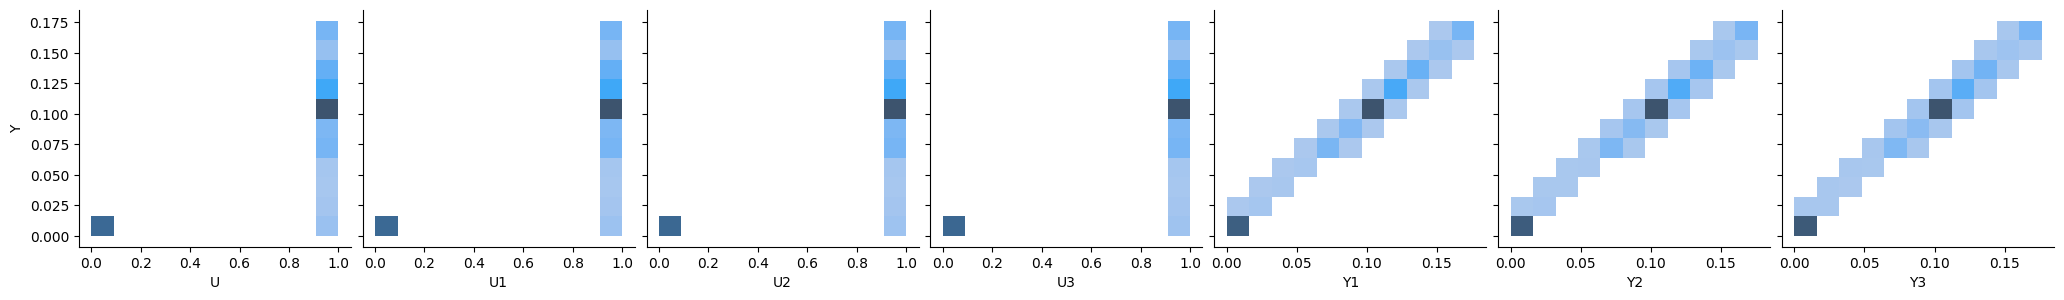

In [28]:
sns.pairplot(datosBal,
             x_vars = ['U','U1','U2','U3','Y1','Y2','Y3'],
             y_vars = ['Y'],
             height= 3,kind='hist') # Scatter entre todas las variables exceptuando time y samples

## Ejercicio

Con base en sus datos, proponga 3 hipotesis para modelos LTI y ajuste.

Analice resultados.

